(f_rs_plot)=


---------------
```{admonition} Learning Objectives
  - Visualize RGB images from remotely sensed data
  - Visualize true-color and false-color composites
  - 
```
```{admonition} Review
* [Data Structures](c_features.md)
* [Raster Data ](c_rasters.md)
* [Opening Remotely Sensed Data](f_rs_io.md)
```
--------------


# Plot Remote Sensed Images
Import required modules and data.

In [1]:
# Import GeoWombat
import geowombat as gw

# import plotting
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

## Plot a Single Band Image

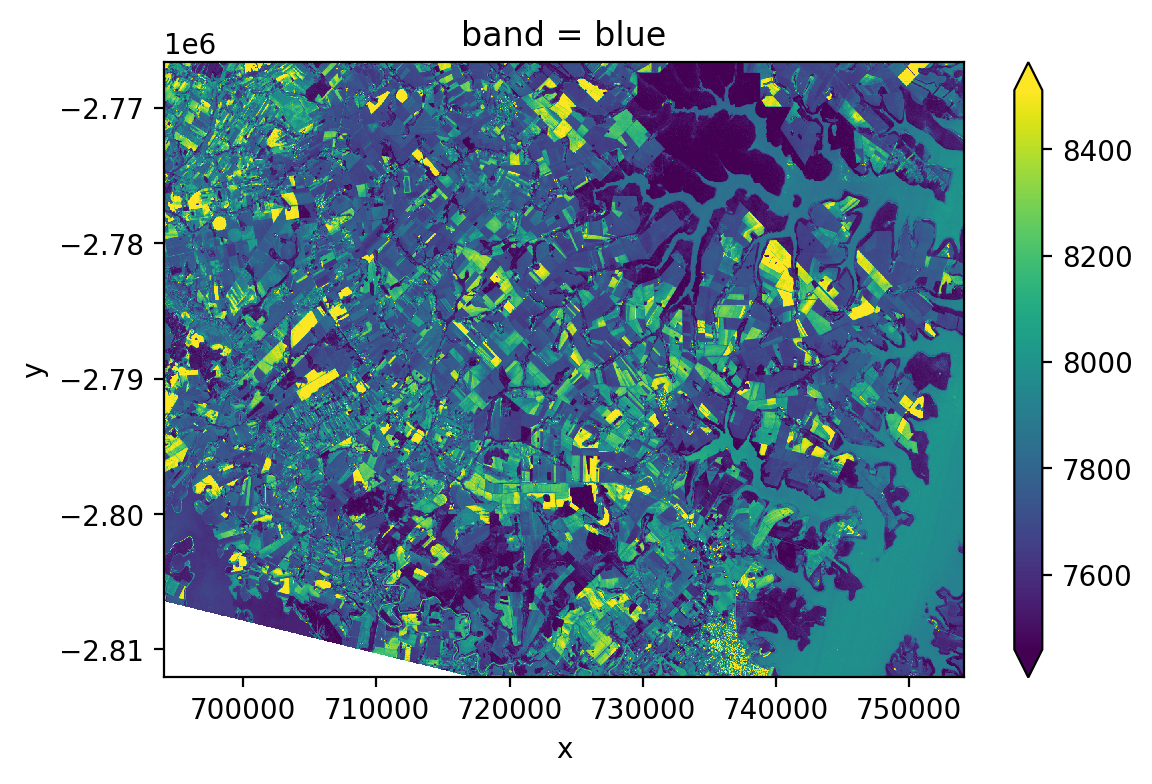

In [2]:
from geowombat.data import l8_224077_20200518_B2 

fig, ax = plt.subplots(dpi=200)

with gw.open(l8_224077_20200518_B2,
                band_names=['blue']) as src:
    src.where(src != 0).sel(band='blue').plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Plot a True Color LandSat Image
Here we open the image, missing data is removed with `.where(src != 0)`, remember the bands in this file are stored in reverse order (blue, green, red), so we put them back into order `.sel(band=[3, 2, 1])`.

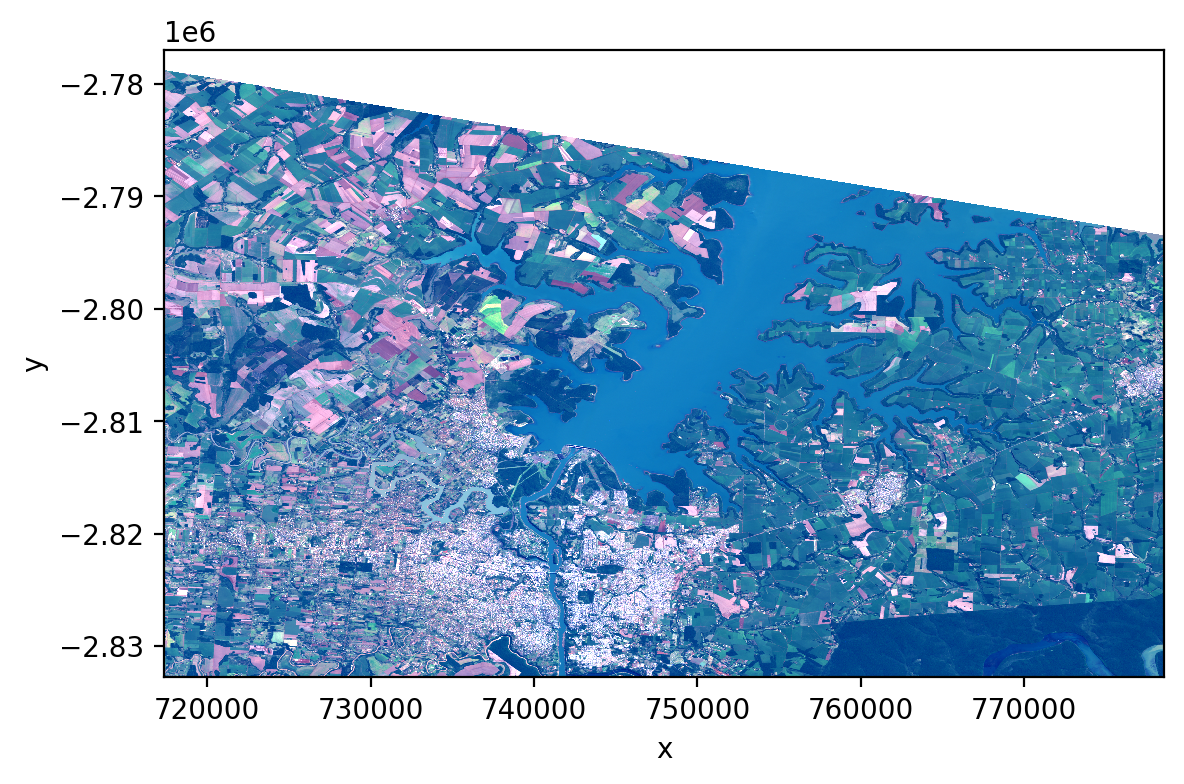

In [3]:
# load example data
from geowombat.data import l8_224078_20200518

fig, ax = plt.subplots(dpi=200)
with gw.open(l8_224078_20200518) as src:
    src.where(src != 0).sel(band=[3, 2, 1]).plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Plot False Color Composites 
We can use the red, green, and blue channels to show different parts of the spectrum. This allows us for instance to "see" near-infrared (nir). Moreover certain combinations of bands allow us to better identify vegetation, urban environments, water, etc. There are many false colored composites that can be used to highlight different features. 

<iframe width="560" height="315" src="https://www.youtube.com/embed/YP0et8l_bvY" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Color Infrared (vegetation)
Here we will look at a common false color combo to assigns the nir band to the color red. This make vegetation appear bright red.

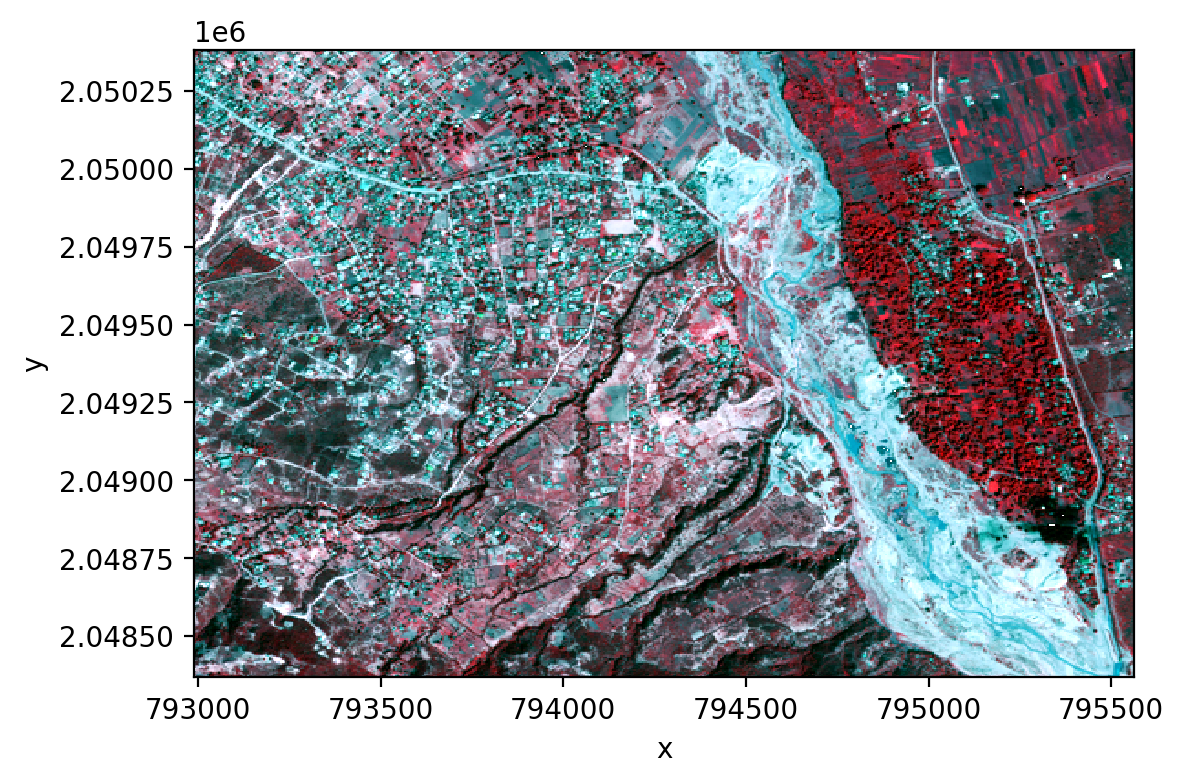

In [4]:
from geowombat.data import rgbn

fig, ax = plt.subplots(dpi=200)

with gw.open(rgbn,
            band_names=['red','green','blue','nir'],) as src:
    src.where(src != 0).sel(band=['nir','red', 'green']).plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)
plt.savefig("rgb_plot.png", dpi=150)

### Common Band Combinations for Landsat 8

| Name    | Band Combination    |
| :--- | ---: |
| Natural Color    | 4 3 2  |
| False Color (urban) |  7 6 4|
| Color Infrared (vegetation) |	5 4 3|
| Agriculture |	6 5 2|
| Atmospheric Penetration |	7 6 5|
| Healthy Vegetation |	5 6 2 |
| Land/Water |	5 6 4|
| Natural With Atmospheric Removal |	7 5 3 |
|Shortwave Infrared |	7 5 4|
|Vegetation Analysis| 	6 5 4|

<!-- 
## Plot Union of two LandSat Images
As an example let's plot the union with `mosaic=True` of two images taken on the same day, but blue band only. Note we rename the band name with `band_names=['blue']`.

```{code-cell} ipython3
# from geowombat.data import l8_224077_20200518_B2, l8_224078_20200518_B2

# fig, ax = plt.subplots(dpi=200)
# filenames = [l8_224077_20200518_B2, l8_224078_20200518_B2]
# with gw.open(filenames,
#                 band_names=['blue'],
#                 mosaic=True,
#                 bounds_by='union') as src:
#     src.where(src != 0).sel(band='blue').plot.imshow(robust=True, ax=ax)
# plt.tight_layout(pad=1)
```

## Plot Intersection of two LandSat Images
Same idea with the intersection, using `bounds_by='intersection'`, we still need to mosaic the two images `mosaic=True`.

```{code-cell} ipython3
# fig, ax = plt.subplots(dpi=200)
# filenames = [l8_224077_20200518_B2, l8_224078_20200518_B2]
# with gw.open(filenames,
#                 band_names=['blue'],
#                 mosaic=True,
#                 bounds_by='intersection') as src:
#     src.where(src != 0).sel(band='blue').plot.imshow(robust=True, ax=ax)
# plt.tight_layout(pad=1)
```
 -->

## Plot LandSat Tile Footprints
Here we set up a more complicated plotting function for near IR 'nir'.  Note the use of `footprint_grid`.

In [5]:
from geowombat.data import l8_224077_20200518_B4, l8_224078_20200518_B4

def plot(bounds_by, ref_image=None, cmap='viridis'):
    fig, ax = plt.subplots(dpi=200)
    with gw.config.update(ref_image=ref_image):
        with gw.open([l8_224077_20200518_B4, l8_224078_20200518_B4],
                        band_names=['nir'],
                        chunks=256,
                        mosaic=True,
                        bounds_by=bounds_by) as srca:
            # Plot the NIR band
            srca.where(srca != 0).sel(band='nir').plot.imshow(robust=True, cbar_kwargs={'label': 'DN'}, ax=ax)
            # Plot the image chunks
            srca.gw.chunk_grid.plot(color='none', edgecolor='k', ls='-', lw=0.5, ax=ax)
            # Plot the image footprints
            srca.gw.footprint_grid.plot(color='none', edgecolor='orange', lw=2, ax=ax)
            # Label the image footprints
            for row in srca.gw.footprint_grid.itertuples(index=False):
                ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y,
                            s=50, color='red', edgecolor='white', lw=1)
                ax.annotate(row.footprint.replace('.TIF', ''),
                            (row.geometry.centroid.x, row.geometry.centroid.y),
                            color='black',
                            size=8,
                            ha='center',
                            va='center',
                            path_effects=[pe.withStroke(linewidth=1, foreground='white')])
            # Set the display bounds
            ax.set_ylim(srca.gw.footprint_grid.total_bounds[1]-10, srca.gw.footprint_grid.total_bounds[3]+10)
            ax.set_xlim(srca.gw.footprint_grid.total_bounds[0]-10, srca.gw.footprint_grid.total_bounds[2]+10)
    title = f'Image {bounds_by}' if bounds_by else str(Path(ref_image).name.split('.')[0]) + ' as reference'
    size = 12 if bounds_by else 8
    ax.set_title(title, size=size)
    plt.tight_layout(pad=1)

The two plots below illustrate how two images can be mosaicked. The orange grids highlight the image footprints while the black grids illustrate the ``DataArray`` chunks.

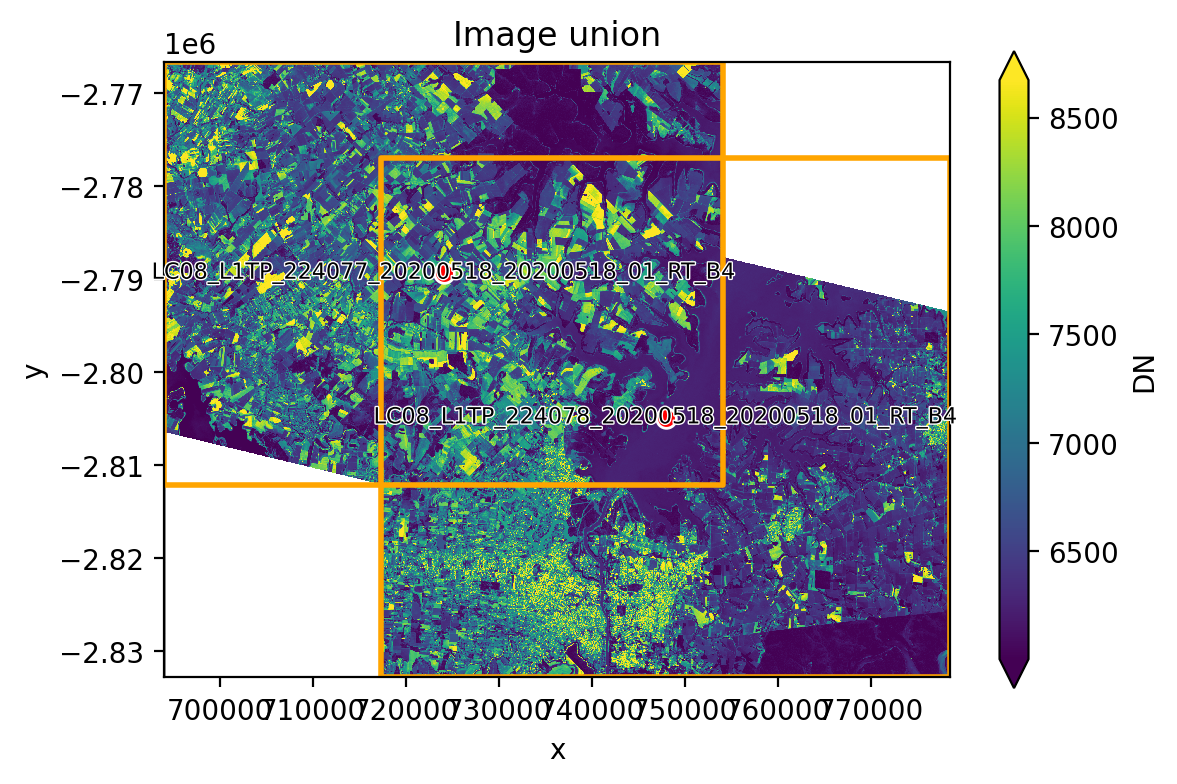

In [6]:
plot('union')